In [1]:
import os, sys
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from shutil import copyfile
import seaborn as sns

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rcParams["figure.figsize"] = (20,3)

np.random.seed(42)
tf.random.set_seed(42)

# Below code is for enabling only particular GPU cards.
# Testing machine contained in total 6 GPUs, but for training only 5 of them were used.
# If your testing set contains less or one card, you need to change it accordingly.
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices([physical_devices[1], physical_devices[2], physical_devices[3], physical_devices[4], physical_devices[5]], 'GPU')

In [2]:
data_dir = '../data'

In [3]:
historic_data_in_minibatch = 250

In [4]:
ema_lengths = [3, 5, 8, 9, 10, 13, 20, 21, 26, 34, 50, 55, 89, 100, 144, 200, 233, historic_data_in_minibatch]
len(ema_lengths)

18

# Data loading

In [5]:
# Loading data from already prepared datasets
X_train, y_train = (
    np.load(os.path.join(data_dir, 'X_train_shuffled_with_mean_model.npz')), 
    np.load(os.path.join(data_dir, 'y_train_shuffled_with_mean_model.npz')))
X_train, y_train = X_train['arr_0'], y_train['arr_0']

X_valid, y_valid = (
    np.load(os.path.join(data_dir, 'X_valid_shuffled_with_mean_model.npz')), 
    np.load(os.path.join(data_dir, 'y_valid_shuffled_with_mean_model.npz')))
X_valid, y_valid = X_valid['arr_0'], y_valid['arr_0']

X_test, y_test = (
    np.load(os.path.join(data_dir, 'X_test_shuffled_with_mean_model.npz')), 
    np.load(os.path.join(data_dir, 'y_test_shuffled_with_mean_model.npz')))
X_test, y_test = X_test['arr_0'], y_test['arr_0']

In [6]:
X_train = X_train.reshape((X_train.shape[0]), X_train.shape[1])
X_test = X_test.reshape((X_test.shape[0]), X_test.shape[1])
X_valid = X_valid.reshape((X_valid.shape[0]), X_valid.shape[1])

## Data scaling

In [7]:
from pickle import dump

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

dump(scaler, open('input_scaler_with_ema_shuffled.pkl', 'wb'))

In [8]:
X_train = X_train.reshape((X_train.shape[0]), X_train.shape[1], 1)
X_test = X_test.reshape((X_test.shape[0]), X_test.shape[1], 1)
X_valid = X_valid.reshape((X_valid.shape[0]), X_valid.shape[1], 1)

In [10]:
features_number = X_train.shape[1]

## Split for two model inputs

In [11]:
X_train_CNN, X_train_Dense = X_train[:, :historic_data_in_minibatch, :], X_train[:, historic_data_in_minibatch:, :] 
X_test_CNN, X_test_Dense = X_test[:, :historic_data_in_minibatch, :], X_test[:, historic_data_in_minibatch:, :] 
X_valid_CNN, X_valid_Dense = X_valid[:, :historic_data_in_minibatch, :], X_valid[:, historic_data_in_minibatch:, :] 

In [14]:
len(y_train), len(y_valid), len(y_test)

(443010, 128616, 64465)

# y categorization

In [16]:
one_ids = np.where(y_train >= 0.9)
zero_ids = np.where(y_train < 0.9)

y_train[one_ids[0], one_ids[1]] = 1
y_train[zero_ids[0], zero_ids[1]] = 0

ones, zeroes = len(one_ids[0]), len(zero_ids[0])
print(f'Positive %: {ones / (ones + zeroes)}')
print(f'Negative %: {1 - (ones / (ones + zeroes))}')

y_train = y_train.astype(np.int)

Positive %: 0.04737364845037358
Negative %: 0.9526263515496264


In [17]:
one_ids = np.where(y_valid >= 0.9)
zero_ids = np.where(y_valid < 0.9)

y_valid[one_ids[0], one_ids[1]] = 1
y_valid[zero_ids[0], zero_ids[1]] = 0

ones, zeroes = len(one_ids[0]), len(zero_ids[0])
print(f'Positive %: {ones / (ones + zeroes)}')
print(f'Negative %: {1 - (ones / (ones + zeroes))}')

y_valid = y_valid.astype(np.int)

Positive %: 0.062239534739068236
Negative %: 0.9377604652609317


In [18]:
one_ids = np.where(y_test >= 0.9)
zero_ids = np.where(y_test < 0.9)

y_test[one_ids[0], one_ids[1]] = 1
y_test[zero_ids[0], zero_ids[1]] = 0

ones, zeroes = len(one_ids[0]), len(zero_ids[0])
print(f'Positive %: {ones / (ones + zeroes)}')
print(f'Negative %: {1 - (ones / (ones + zeroes))}')

y_test = y_test.astype(np.int)

Positive %: 0.05826417435817886
Negative %: 0.9417358256418211


In [19]:
y_all = np.concatenate((y_train, y_valid, y_test))
temp = np.copy(y_all)
temp.shape

one_ids = np.where(temp >= 0.9)
zero_ids = np.where(temp < 0.9)

temp[one_ids[0], one_ids[1]] = 1
temp[zero_ids[0], zero_ids[1]] = 0

ones, zeroes = len(one_ids[0]), len(zero_ids[0])
print(f'Positive %: {ones / (ones + zeroes)}')
print(f'Negative %: {1 - (ones / (ones + zeroes))}')

unique, counts = np.unique(y_all, return_counts=True)
for val, qty in zip(unique, counts):
    print(f'Label {val}: {qty}')

Positive %: 0.05148319973085612
Negative %: 0.9485168002691439
Label 0: 603343
Label 1: 32748


In [2]:
neg, pos = np.unique(y_train, return_counts=True)[1]
total = neg + pos
# weight_for_0 = (1 / neg)*(total)/2.0 
# weight_for_1 = (1 / pos)*(total)/2.0

# class_weight = {0: weight_for_0, 1: weight_for_1}

# print('Weight for class 0: {:.2f}'.format(weight_for_0))
# print('Weight for class 1: {:.2f}'.format(weight_for_1))

# class_weight = {0: weight_for_0, 1: weight_for_1}

### Applying custom weights

In [21]:
class_weight = {0: 1.0, 1: 7.0}

### DS Oversampling
Sample code for dataset oversampling do balance it a little bit. After the tests, in this case it didn't bring any improvement for model training, so was commented out.

In [19]:
# np.random.seed(42)

In [5]:
# bool_train_labels = np.where(y_train == 1.)[0]
# bool_train_labels.shape

In [21]:
# pos_features_CNN = X_train_CNN[bool_train_labels, :, :]
# pos_features_Dense = X_train_Dense[bool_train_labels, :, :]
# neg_features_CNN = X_train_CNN[~bool_train_labels, :, :]
# neg_features_Dense = X_train_Dense[~bool_train_labels, :, :]

# pos_labels = y_train[bool_train_labels]
# neg_labels = y_train[~bool_train_labels]

In [3]:
# ids = np.arange(len(pos_features_CNN))
# choices = np.random.choice(ids, len(neg_labels))

# res_pos_features_CNN = pos_features_CNN[choices]
# res_pos_features_Dense = pos_features_Dense[choices]
# res_pos_labels = pos_labels[choices]

# res_pos_features_CNN.shape, res_pos_features_Dense.shape

In [4]:
# resampled_features_CNN = np.concatenate([res_pos_features_CNN, neg_features_CNN], axis=0)
# resampled_features_Dense = np.concatenate([res_pos_features_Dense, neg_features_Dense], axis=0)
# resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

# order = np.arange(len(resampled_labels))
# np.random.shuffle(order)
# resampled_features_CNN = resampled_features_CNN[order]
# resampled_features_Dense = resampled_features_Dense[order]
# resampled_labels = resampled_labels[order]

# resampled_features_CNN.shape, resampled_features_Dense.shape

# Classification Model with custom weights

## TensorBoard config

In [6]:
tf.keras.backend.clear_session()

In [7]:
# Training of this model was initially done from different location,
# and the actual tensorboard metrics can be found in directory `train` and `validation`
# If you want to run your own training based on this notebook,
# please create `my_dictionaries` directory on your own. 
# All TensorBoard metrics will be saved there.
root_logdir = os.path.join(os.curdir, 'my_dictionaries')

def get_run_logdir():
    import time
    run_id = time.strftime('przebieg_%Y_%m_%d-%H_%M_%S')
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
file_writer = tf.summary.create_file_writer(run_logdir + "/metrics")
file_writer.set_as_default()

In [26]:
try:
    log.removeHandler(fh)
except Exception as err:
    print("Handler or log instance doesn't exists.")
else:
    print(f'Handler {fh} removed correctly. All handlers:\n{log.handlers}')

Handler or log instance doesn't exists.


In [27]:
import logging

# get TF logger
log = logging.getLogger('tensorflow')
log.setLevel(logging.DEBUG)

# create formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# create file handler which logs even debug messages
directory = os.path.join(run_logdir, 'tensorflow.log')
os.makedirs(run_logdir, exist_ok=True)
open(directory, 'w').close()
fh = logging.FileHandler(directory)
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)
log.addHandler(fh)

In [28]:
config = {
    'cnn_input_shape': [X_train_CNN.shape[1], 1],
    'kernel_initializer': 'he_normal',
    'statistical_input_shape': [X_train_Dense.shape[1], 1],
    'statistical_dense1_neurons_qty': X_train_Dense.shape[1],
    'batch_size': 6000,
    'n': 120,
    'm': 40,
    'lr_in': 0.03,
    'lr_max': 1e-1,
    'lr_min': 1e-4,
    'momentum_min': 0.8,
    'momentum_max': 0.95
}

log.info(f'Config:\n{config}')

INFO:tensorflow:Config:
{'cnn_input_shape': [250, 1], 'kernel_initializer': 'he_normal', 'statistical_input_shape': [26, 1], 'statistical_dense1_neurons_qty': 26, 'batch_size': 6000, 'n': 120, 'm': 40, 'lr_in': 0.03, 'lr_max': 0.1, 'lr_min': 0.0001, 'momentum_min': 0.8, 'momentum_max': 0.95}


In [29]:
import json

with open(os.path.join(run_logdir, 'config.json'), 'w') as config_json:
    json.dump(config, config_json)

In [30]:
# 1cycle Learning Rate Scheduler
log.info('Using 1cycle Learning Rate Scheduler')

learning_rates = []

_epochs1, _lrs1 = np.array([1, config['n']]).reshape((-1, 1)), np.array([config['lr_in'], config['lr_max']]).reshape((-1, 1))
_epochs2, _lrs2 = np.array([config['n'], 2*config['n']]).reshape((-1, 1)), np.array([config['lr_max'], config['lr_in']]).reshape((-1, 1))
_epochs3, _lrs3 = np.array([2*config['n'], 2*config['n'] + config['m']]).reshape((-1, 1)), np.array([config['lr_in'], config['lr_min']]).reshape((-1, 1))

reg1 = LinearRegression().fit(_epochs1, _lrs1)
reg2 = LinearRegression().fit(_epochs2, _lrs2)
reg3 = LinearRegression().fit(_epochs3, _lrs3)

def one_cycle_lr_scheduler(epoch, curr_lr):
    epoch = epoch + 1
    if epoch <= config['n']:
        lr = reg1.predict(np.array([epoch]).reshape((-1,1)))[0][0]
    elif epoch > config['n'] and epoch <= 2 * config['n']:
        lr = reg2.predict(np.array([epoch]).reshape((-1,1)))[0][0]
    else:
        lr = reg3.predict(np.array([epoch]).reshape((-1,1)))[0][0]
        
    learning_rates.append(lr)
    
    log.info(f'New lr = {lr}, epoch = {epoch}')
    tf.summary.scalar('learning_rate', data=lr, step=epoch-1)
    return lr

one_cycle_scheduler = tf.keras.callbacks.LearningRateScheduler(one_cycle_lr_scheduler)

INFO:tensorflow:Using 1cycle Learning Rate Scheduler


In [31]:
# 1cycle Momentum scheduler
log.info('Using 1cycle Momentum')

momentum_rates = []

_momentum_epochs1, _momentums1 = np.array([1, config['n']]).reshape((-1, 1)), np.array([config['momentum_max'], config['momentum_min']]).reshape((-1, 1))
_momentum_epochs2, _momentums2 = np.array([config['n'], 2*config['n']]).reshape((-1, 1)), np.array([config['momentum_min'], config['momentum_max']]).reshape((-1, 1))

momentum_reg1 = LinearRegression().fit(_momentum_epochs1, _momentums1)
momentum_reg2 = LinearRegression().fit(_momentum_epochs2, _momentums2)


class MomentumCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        epoch = epoch + 1
        print(f'Epoch: {epoch}')
        print(f'Current momentum: {self.model.optimizer.momentum}')
        if epoch <= config['n']: 
            momentum = momentum_reg1.predict(np.array([epoch]).reshape((-1,1)))[0][0]
        elif epoch > config['n'] and epoch <= 2 * config['n']:
            momentum = momentum_reg2.predict(np.array([epoch]).reshape((-1,1)))[0][0]
        else:
            momentum = config['momentum_max']
            
        momentum_rates.append(momentum)
        
        self.model.optimizer.momentum = momentum
        print(f'Updated momentum: {self.model.optimizer.momentum}')
        tf.summary.scalar('momentum', data=momentum, step=epoch-1)


INFO:tensorflow:Using 1cycle Momentum


In [32]:
# Callback for collecting learning rate value over the process of training
custom_lrs = []

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        custom_lrs.append({'epoch': epoch, 'lr': self.model.optimizer._decayed_lr('float32').numpy()})
        print(f"Epoch {epoch}. Current lr = {self.model.optimizer._decayed_lr('float32').numpy()}")

In [33]:
from importlib import import_module, reload
from shutil import copyfile

model_creation = import_module('model_creation_categorical_reworked')
reload(model_creation)

log.info('\n\nBuilding model:\n')
# The quantity of provided devices depends from number of GPUs in local system.
devices=["/gpu:0", "/gpu:1", "/gpu:2", "/gpu:3", "/gpu:4"]
model = model_creation.build_model(config, devices=devices)

copyfile('model_creation_categorical_reworked.py', os.path.join(run_logdir, 'model_creation_categorical_reworked.py'))

INFO:tensorflow:

Building model:

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replic

'./moje_dzienniki/przebieg_2021_06_05-13_41_25/model_creation_categorical_reworked.py'

In [34]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 1)]     0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 250, 1)       4           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 250, 256)     38656       batch_normalization[0][0]        
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 125, 256)     0           conv1d[0][0]                     
______________________________________________________________________________________________

## Bias correction
Initial bias correction is sometimes performed to adjust early loss value when training data on unbalanced DS. After the tests, in this case it didn't bring any improvement for model training, so was commented out.

In [8]:
# model.predict((X_train_CNN[:10], X_train_Dense[:10]))

In [9]:
# results = model.evaluate((X_train_CNN, X_train_Dense), y_train, batch_size=config['batch_size'] * len(devices))
# print("Loss: {:0.4f}".format(results[0]))

In [10]:
# initial_bias = np.log([pos/neg])
# initial_bias

In [11]:
# from importlib import import_module, reload
# from shutil import copyfile

# model_creation = import_module('model_creation_categorical')
# reload(model_creation)

# log.info('\n\nBuilding model:\n')
# devices=["/gpu:0", "/gpu:1", "/gpu:2", "/gpu:3", "/gpu:4"]
# model = model_creation.build_model(config, devices=devices, add_dropout=True, add_batch_norm=True, cust_lr_scheduler = lr_schedule, output_bias=initial_bias)

# copyfile('model_creation_categorical.py', os.path.join(run_logdir, 'model_creation_categorical.py'))

In [12]:
# pos/(total)

In [13]:
# model.predict((X_train_CNN[:10], X_train_Dense[:10]))

In [14]:
# results = model.evaluate((X_train_CNN, X_train_Dense), y_train, batch_size=config['batch_size'] * len(devices))
# print("Loss: {:0.4f}".format(results[0]))

# Model training
All training and validation metrics can be found in tensorboard folders and visualized by tensorboard.

In [35]:
log.info('\n\nModel fitting:\n\n')
history = model.fit(
    (X_train_CNN, X_train_Dense), y_train, 
    epochs=280, 
    batch_size = config['batch_size'] * len(devices), 
    validation_data=((X_valid_CNN, X_valid_Dense), y_valid), 
    verbose=0,
    class_weight=class_weight,
    callbacks=[
        tensorboard_cb, 
        CustomCallback(), 
        one_cycle_scheduler, 
        MomentumCallback()
    ]
)

INFO:tensorflow:

Model fitting:


INFO:tensorflow:New lr = 0.030000000000000013, epoch = 1
Epoch: 1
Current momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.95>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.95>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.95>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.95>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.95>
}
Updated momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.95>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.95>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.95>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.95>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.95>
}
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/devic

Epoch: 6
Current momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.944958>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.944958>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.944958>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.944958>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.944958>
}
Updated momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.94369745>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.94369745>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.94369745>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.94369745>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.94369745>
}
Epoch 5. Current lr = 0.03294117748737335
INFO:tensorflow:New lr = 0.03352941176470589, epoch = 7
Epoch: 

Epoch 13. Current lr = 0.0376470573246479
INFO:tensorflow:New lr = 0.03823529411764707, epoch = 15
Epoch: 15
Current momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.9336134>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.9336134>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.9336134>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.9336134>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.9336134>
}
Updated momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.93235296>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.93235296>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.93235296>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.93235296>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.93235296>
}


Epoch 22. Current lr = 0.042941175401210785
INFO:tensorflow:New lr = 0.04352941176470589, epoch = 24
Epoch: 24
Current momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.9222689>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.9222689>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.9222689>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.9222689>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.9222689>
}
Updated momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.9210084>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.9210084>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.9210084>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.9210084>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.9210084>
}
Epo

Epoch 31. Current lr = 0.048235293477773666
INFO:tensorflow:New lr = 0.04882352941176471, epoch = 33
Epoch: 33
Current momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.9109244>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.9109244>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.9109244>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.9109244>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.9109244>
}
Updated momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.90966386>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.90966386>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.90966386>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.90966386>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.90966386>


Epoch 40. Current lr = 0.05352941155433655
INFO:tensorflow:New lr = 0.054117647058823534, epoch = 42
Epoch: 42
Current momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.8995798>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.8995798>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.8995798>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.8995798>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.8995798>
}
Updated momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.8983193>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.8983193>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.8983193>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.8983193>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.8983193>
}
Epo

Epoch 49. Current lr = 0.05882352963089943
INFO:tensorflow:New lr = 0.05941176470588236, epoch = 51
Epoch: 51
Current momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.8882353>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.8882353>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.8882353>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.8882353>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.8882353>
}
Updated momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.8869748>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.8869748>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.8869748>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.8869748>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.8869748>
}
Epoc

Epoch 58. Current lr = 0.06411764770746231
INFO:tensorflow:New lr = 0.06470588235294118, epoch = 60
Epoch: 60
Current momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.8768908>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.8768908>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.8768908>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.8768908>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.8768908>
}
Updated momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.87563026>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.87563026>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.87563026>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.87563026>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.87563026>
}

Epoch 67. Current lr = 0.0694117620587349
INFO:tensorflow:New lr = 0.07, epoch = 69
Epoch: 69
Current momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.8655462>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.8655462>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.8655462>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.8655462>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.8655462>
}
Updated momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.8642857>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.8642857>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.8642857>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.8642857>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.8642857>
}
Epoch 68. Current lr

Epoch 76. Current lr = 0.07470588386058807
INFO:tensorflow:New lr = 0.07529411764705882, epoch = 78
Epoch: 78
Current momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.8542017>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.8542017>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.8542017>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.8542017>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.8542017>
}
Updated momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.85294116>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.85294116>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.85294116>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.85294116>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.85294116>
}

Epoch 85. Current lr = 0.07999999821186066
INFO:tensorflow:New lr = 0.08058823529411765, epoch = 87
Epoch: 87
Current momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.8428571>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.8428571>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.8428571>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.8428571>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.8428571>
}
Updated momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.84159666>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.84159666>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.84159666>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.84159666>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.84159666>
}

Epoch 94. Current lr = 0.08529412001371384
INFO:tensorflow:New lr = 0.08588235294117647, epoch = 96
Epoch: 96
Current momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.83151263>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.83151263>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.83151263>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.83151263>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.83151263>
}
Updated momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.8302521>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.8302521>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.8302521>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.8302521>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.8302521>
}

Epoch 103. Current lr = 0.09058823436498642
INFO:tensorflow:New lr = 0.09117647058823529, epoch = 105
Epoch: 105
Current momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.8201681>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.8201681>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.8201681>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.8201681>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.8201681>
}
Updated momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.81890756>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.81890756>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.81890756>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.81890756>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.81890756

Epoch 112. Current lr = 0.0958823561668396
INFO:tensorflow:New lr = 0.09647058823529411, epoch = 114
Epoch: 114
Current momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.8088235>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.8088235>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.8088235>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.8088235>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.8088235>
}
Updated momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.807563>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.807563>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.807563>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.807563>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.807563>
}
Epoch 1

Epoch 121. Current lr = 0.09883332997560501
INFO:tensorflow:New lr = 0.09825, epoch = 123
Epoch: 123
Current momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.8025>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.8025>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.8025>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.8025>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.8025>
}
Updated momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.80375>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.80375>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.80375>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.80375>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.80375>
}
Epoch 122. Current lr = 0.098250001668

Epoch 130. Current lr = 0.09358333051204681
INFO:tensorflow:New lr = 0.093, epoch = 132
Epoch: 132
Current momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.81375>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.81375>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.81375>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.81375>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.81375>
}
Updated momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.815>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.815>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.815>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.815>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.815>
}
Epoch 131. Current lr = 0.09300000220537186
I

Epoch 139. Current lr = 0.08833333104848862
INFO:tensorflow:New lr = 0.08775000000000001, epoch = 141
Epoch: 141
Current momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.825>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.825>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.825>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.825>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.825>
}
Updated momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.82625>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.82625>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.82625>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.82625>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.82625>
}
Epoch 140. Current lr = 0.08775

Epoch 148. Current lr = 0.08308333158493042
INFO:tensorflow:New lr = 0.0825, epoch = 150
Epoch: 150
Current momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.83625>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.83625>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.83625>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.83625>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.83625>
}
Updated momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.8375>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.8375>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.8375>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.8375>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.8375>
}
Epoch 149. Current lr = 0.0825000032782

Epoch 157. Current lr = 0.07783333212137222
INFO:tensorflow:New lr = 0.07725, epoch = 159
Epoch: 159
Current momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.8475>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.8475>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.8475>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.8475>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.8475>
}
Updated momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.84875>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.84875>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.84875>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.84875>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.84875>
}
Epoch 158. Current lr = 0.077249996364

Epoch 166. Current lr = 0.07258333265781403
INFO:tensorflow:New lr = 0.07200000000000001, epoch = 168
Epoch: 168
Current momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.85875>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.85875>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.85875>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.85875>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.85875>
}
Updated momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.86>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.86>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.86>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.86>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.86>
}
Epoch 167. Current lr = 0.0719999969

Epoch 175. Current lr = 0.06733333319425583
INFO:tensorflow:New lr = 0.06675, epoch = 177
Epoch: 177
Current momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.87>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.87>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.87>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.87>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.87>
}
Updated momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.87125>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.87125>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.87125>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.87125>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.87125>
}
Epoch 176. Current lr = 0.06674999743700027
INFO

Epoch 184. Current lr = 0.06208333373069763
INFO:tensorflow:New lr = 0.0615, epoch = 186
Epoch: 186
Current momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.88125>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.88125>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.88125>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.88125>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.88125>
}
Updated momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.8825>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.8825>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.8825>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.8825>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.8825>
}
Epoch 185. Current lr = 0.0615000016987

Epoch 193. Current lr = 0.056833334267139435
INFO:tensorflow:New lr = 0.05625000000000001, epoch = 195
Epoch: 195
Current momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.8925>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.8925>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.8925>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.8925>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.8925>
}
Updated momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.89375>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.89375>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.89375>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.89375>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.89375>
}
Epoch 194. Current lr = 0

Epoch 202. Current lr = 0.05158333480358124
INFO:tensorflow:New lr = 0.051000000000000004, epoch = 204
Epoch: 204
Current momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.90375>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.90375>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.90375>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.90375>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.90375>
}
Updated momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.905>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.905>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.905>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.905>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.905>
}
Epoch 203. Current lr = 0.0509

Epoch 211. Current lr = 0.04633333161473274
INFO:tensorflow:New lr = 0.04575, epoch = 213
Epoch: 213
Current momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.915>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.915>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.915>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.915>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.915>
}
Updated momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.91625>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.91625>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.91625>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.91625>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.91625>
}
Epoch 212. Current lr = 0.04574999958276749

Epoch 220. Current lr = 0.041083332151174545
INFO:tensorflow:New lr = 0.04050000000000001, epoch = 222
Epoch: 222
Current momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.92625>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.92625>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.92625>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.92625>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.92625>
}
Updated momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.9275>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.9275>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.9275>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.9275>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.9275>
}
Epoch 221. Current lr = 0

Epoch 229. Current lr = 0.03583333268761635
INFO:tensorflow:New lr = 0.035250000000000004, epoch = 231
Epoch: 231
Current momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.9375>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.9375>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.9375>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.9375>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.9375>
}
Updated momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.93875>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.93875>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.93875>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.93875>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.93875>
}
Epoch 230. Current lr = 0

Epoch 238. Current lr = 0.03058333322405815
INFO:tensorflow:New lr = 0.03, epoch = 240
Epoch: 240
Current momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.94875>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.94875>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.94875>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.94875>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.94875>
}
Updated momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.95>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.95>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.95>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.95>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.95>
}
Epoch 239. Current lr = 0.029999999329447746
INFO:t

Epoch 247. Current lr = 0.02401999942958355
INFO:tensorflow:New lr = 0.0232725, epoch = 249
Epoch: 249
Current momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.95>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.95>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.95>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.95>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.95>
}
Updated momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.95>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.95>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.95>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.95>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.95>
}
Epoch 248. Current lr = 0.023272499442100525
INFO:tensorflow:

Epoch 256. Current lr = 0.017292499542236328
INFO:tensorflow:New lr = 0.016545000000000004, epoch = 258
Epoch: 258
Current momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.95>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.95>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.95>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.95>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.95>
}
Updated momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.95>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.95>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.95>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.95>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.95>
}
Epoch 257. Current lr = 0.016544999554753304
INFO

Epoch 265. Current lr = 0.010564999654889107
INFO:tensorflow:New lr = 0.009817500000000007, epoch = 267
Epoch: 267
Current momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.95>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.95>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.95>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.95>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.95>
}
Updated momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.95>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.95>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.95>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.95>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.95>
}
Epoch 266. Current lr = 0.009817499667406082
INFO

Epoch 274. Current lr = 0.003837500000372529
INFO:tensorflow:New lr = 0.0030900000000000094, epoch = 276
Epoch: 276
Current momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.95>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.95>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.95>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.95>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.95>
}
Updated momentum: MirroredVariable:{
  0: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.95>,
  1: <tf.Variable 'momentum/replica_1:0' shape=() dtype=float32, numpy=0.95>,
  2: <tf.Variable 'momentum/replica_2:0' shape=() dtype=float32, numpy=0.95>,
  3: <tf.Variable 'momentum/replica_3:0' shape=() dtype=float32, numpy=0.95>,
  4: <tf.Variable 'momentum/replica_4:0' shape=() dtype=float32, numpy=0.95>
}
Epoch 275. Current lr = 0.0030900000128895044
IN

In [36]:
model.evaluate((X_test_CNN, X_test_Dense), y_test, return_dict=True)

2015/2015 [==============================] - 20s 10ms/step - fp: 982.0000 - loss: 0.3386 - recall: 0.1483 - prc: 0.1212 - auc: 0.5661 - precision: 0.3619 - binary_accuracy: 0.9351 - fn: 3199.0000 - tp: 557.0000 - tn: 59727.0000


{'fp': 982.0,
 'loss': 0.33862707018852234,
 'recall': 0.148296058177948,
 'prc': 0.12117315828800201,
 'auc': 0.5660603046417236,
 'precision': 0.36192333698272705,
 'binary_accuracy': 0.9351431131362915,
 'fn': 3199.0,
 'tp': 557.0,
 'tn': 59727.0}

## Learning on balanced DS
In case when DS balancing was performed

In [16]:
# resampled_steps_per_epoch = np.ceil(2.0*neg/(config['batch_size'] * len(devices)))
# resampled_steps_per_epoch

In [17]:
# log.info('\n\nModel fitting:\n\n')
# history = model.fit(
#     (resampled_features_CNN, resampled_features_Dense), resampled_labels, 
#     epochs=280, 
#     batch_size = config['batch_size'] * len(devices), 
#     steps_per_epoch=resampled_steps_per_epoch,
#     validation_data=((X_valid_CNN, X_valid_Dense), y_valid), 
#     callbacks=[
#         tensorboard_cb, 
#         CustomCallback(), 
#     ]
# )

In [18]:
# evaluate_res = model.evaluate((X_test_CNN, X_test_Dense), y_test, return_dict=True)
# evaluate_res

# Sample model metrics after training

In [37]:
y_pred = model.predict((X_test_CNN, X_test_Dense))
log.info(f'\n\nPredicted min, max range: {np.min(y_pred), np.max(y_pred)}\n')

INFO:tensorflow:

Predicted min, max range: (7.156159e-27, 0.99995863)



In [42]:
# Applying treshold for classification probability
_y_pred = np.copy(y_pred)
_pred_one = np.where(_y_pred >= 0.9)
_pred_zero = np.where(_y_pred < 0.9)

_y_pred[_pred_one] = 1.0
_y_pred[_pred_zero] = 0.0

## Confusion matrixes

total: 64465
[[0.92650275 0.01523307]
 [0.04962383 0.00864035]]


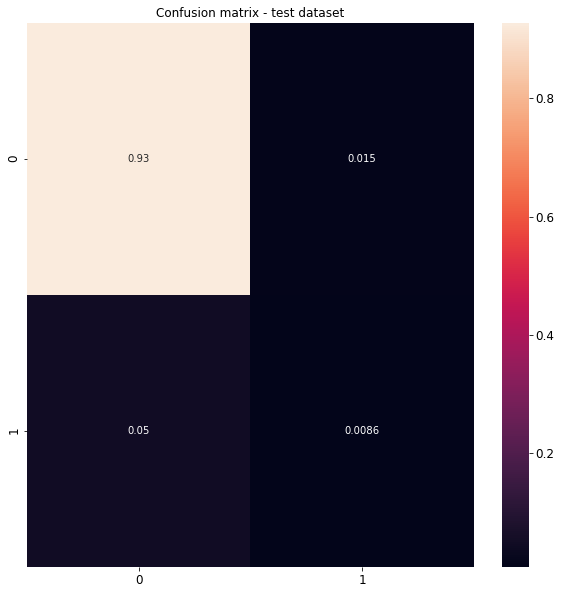

In [46]:
plt.figure(figsize=(10, 10))
cm = sklearn.metrics.confusion_matrix(y_test, _y_pred)
print(f'total: {np.sum(cm)}')
cm = cm / np.sum(cm)
print(cm)
sns.heatmap(cm, annot=True, annot_kws={'fontsize': 'xx-large'})
fname = os.path.join(run_logdir, 'confusion_matrix_test.svg')
plt.title('Confusion matrix - test dataset')
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.savefig(fname, format='svg')
plt.show()

total: 443010
[[0.94471005 0.0079163 ]
 [0.00637457 0.04099907]]


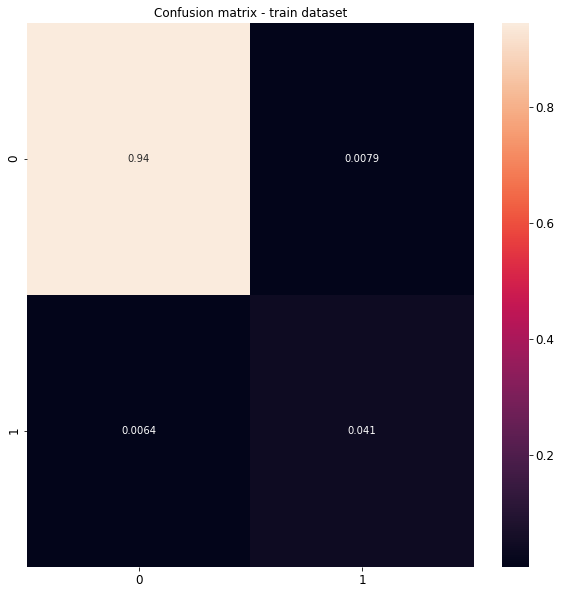

In [47]:
y_train_pred = model.predict((X_train_CNN, X_train_Dense))
_y_train_pred = np.copy(y_train_pred)
_pred_one = np.where(_y_train_pred >= 0.9)
_pred_zero = np.where(_y_train_pred < 0.9)

_y_train_pred[_pred_one] = 1.0
_y_train_pred[_pred_zero] = 0.0

plt.figure(figsize=(10, 10))
cm = sklearn.metrics.confusion_matrix(y_train, _y_train_pred)
print(f'total: {np.sum(cm)}')
cm = cm / np.sum(cm)
print(cm)
sns.heatmap(cm, annot=True, annot_kws={'fontsize': 'xx-large'})
fname = os.path.join(run_logdir, 'confusion_matrix_train.svg')
plt.title('Confusion matrix - train dataset')
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.savefig(fname, format='svg')
plt.show()

total: 128616
[[0.89805312 0.03970735]
 [0.04165112 0.02058842]]


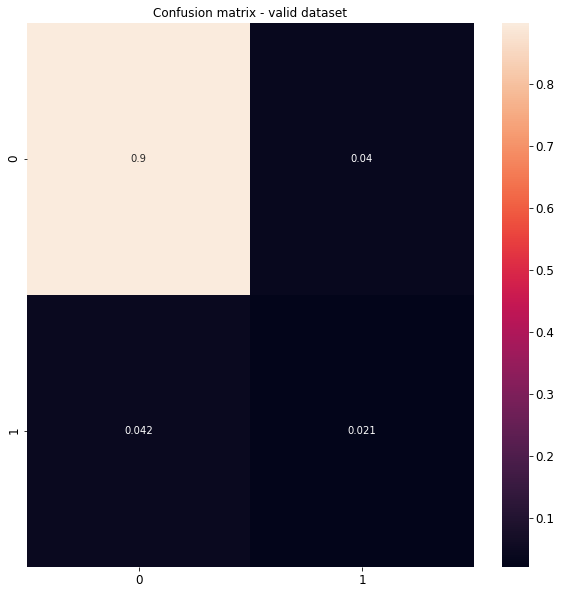

In [48]:
y_valid_pred = model.predict((X_valid_CNN, X_valid_Dense))
_y_valid_pred = np.copy(y_valid_pred)
_pred_one = np.where(_y_valid_pred >= 0.9)
_pred_zero = np.where(_y_valid_pred < 0.9)

_y_valid_pred[_pred_one] = 1.0
_y_valid_pred[_pred_zero] = 0.0

plt.figure(figsize=(10, 10))
cm = sklearn.metrics.confusion_matrix(y_valid, _y_valid_pred)
print(f'total: {np.sum(cm)}')
cm = cm / np.sum(cm)
print(cm)
sns.heatmap(cm, annot=True, annot_kws={'fontsize': 'xx-large'})
fname = os.path.join(run_logdir, 'confusion_matrix_valid.svg')
plt.title('Confusion matrix - valid dataset')
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.savefig(fname, format='svg')
plt.show()

## Classification reports

In [49]:
report = sklearn.metrics.classification_report(y_test, _y_pred)
print('Test dataset')
print(report)
with open(os.path.join(run_logdir, 'classification_report_test.txt'), 'w') as cr_file:
    cr_file.writelines(report)

Test dataset
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     60709
           1       0.36      0.15      0.21      3756

    accuracy                           0.94     64465
   macro avg       0.66      0.57      0.59     64465
weighted avg       0.91      0.94      0.92     64465



In [50]:
report = sklearn.metrics.classification_report(y_train, _y_train_pred)
print('Train dataset')
print(report)
with open(os.path.join(run_logdir, 'classification_report_test_train.txt'), 'w') as cr_file:
    cr_file.writelines(report)

Train dataset
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    422023
           1       0.84      0.87      0.85     20987

    accuracy                           0.99    443010
   macro avg       0.92      0.93      0.92    443010
weighted avg       0.99      0.99      0.99    443010



In [51]:
report = sklearn.metrics.classification_report(y_valid, _y_valid_pred)
print('Valid dataset')
print(report)
with open(os.path.join(run_logdir, 'classification_report_test_valid.txt'), 'w') as cr_file:
    cr_file.writelines(report)

Valid dataset
              precision    recall  f1-score   support

           0       0.96      0.96      0.96    120611
           1       0.34      0.33      0.34      8005

    accuracy                           0.92    128616
   macro avg       0.65      0.64      0.65    128616
weighted avg       0.92      0.92      0.92    128616



## ROC curve

In [53]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives rate (1-Specificity) [%]')
    plt.ylabel('True positives rate (Sensitivity) [%]')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

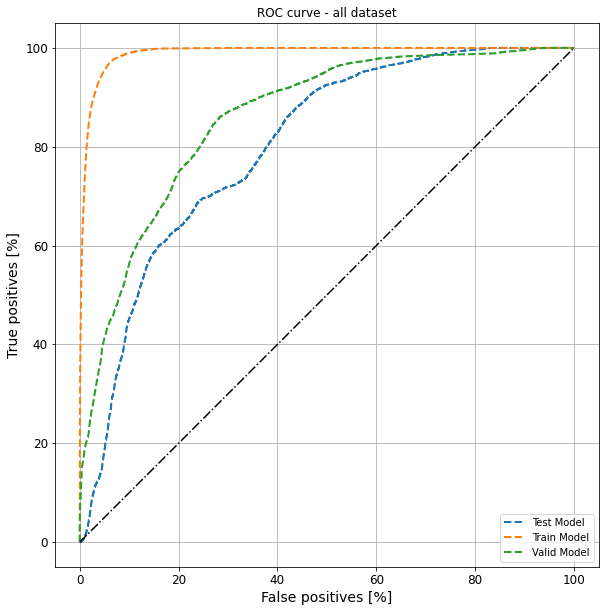

In [54]:
plt.figure(figsize=(10,10))
plot_roc("Test Model", y_test, y_pred, linestyle='--')
plot_roc("Train Model", y_train, y_train_pred, linestyle='--')
plot_roc("Valid Model", y_valid, y_valid_pred, linestyle='--')
plt.plot([0, 100], [0, 100], '-.', c='black')
plt.legend(loc='lower right')
fname = os.path.join(run_logdir, 'roc_curve_all.svg')
plt.title('ROC curve - all dataset')
plt.savefig(fname, format='svg')
plt.show()

## PRC - curve

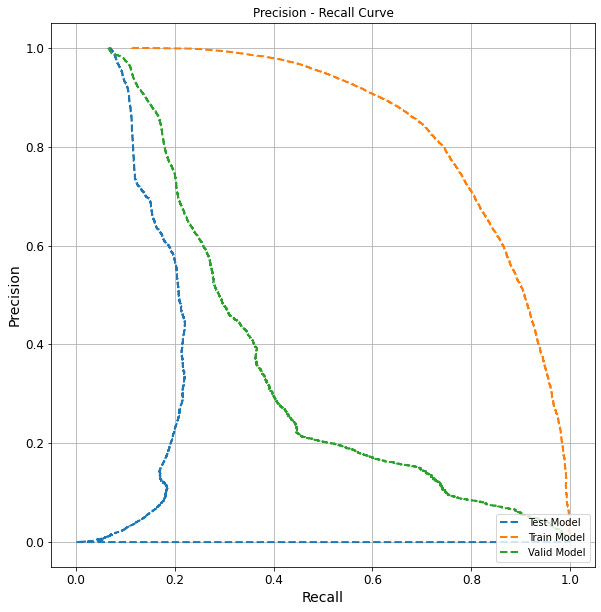

In [55]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    

plt.figure(figsize=(10,10))
plot_prc("Test Model", y_test, y_pred, linestyle='--')
plot_prc("Train Model", y_train, y_train_pred, linestyle='--')
plot_prc("Valid Model", y_valid, y_valid_pred, linestyle='--')
plt.legend(loc='lower right')
plt.title('Precision - Recall Curve')
fname = os.path.join(run_logdir, 'prc_curve.svg')
plt.savefig(fname, format='svg')
plt.show()

# Saving the model

In [19]:
experiment_run_id = run_logdir.split(sep='/')[-1]
model.save(os.path.join(run_logdir, f'trained_model-{experiment_run_id}'))
copyfile('entry_model-categorical_rework.ipynb', os.path.join(run_logdir, 'entry_model-categorical_rework.ipynb'))